In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def optimize_bess(hourly_prices, capacity, initial_charge_level, charge_efficiency, discharge_efficiency):
    """
    Calculates optimal charge/discharge strategy for a BESS over a 24-hour period.
    The strategy is based on comparing the price to the average price.
    
    Returns:
    - profit (float): Total profit made from arbitrage.
    - decisions (list): Hourly decision ('Charge', 'Discharge', or 'Hold').
    - initial_cost (float): Cost if all power for charging was bought (for cost saved analysis).
    - final_charge_level (float): Charge level at the end of the period.
    """
    
    if not isinstance(hourly_prices, np.ndarray):
        hourly_prices = np.array(hourly_prices)

    profit = 0
    charge_level = initial_charge_level
    decisions = []
    charge_levels_over_time = [initial_charge_level] # Track state of charge

    avg_price = hourly_prices.mean()
    
    # Max hourly charge/discharge rate (e.g., C/10 or 10% of capacity)
    max_power = 0.1 * capacity 
    
    for price in hourly_prices:
        
        # Simple decision logic: Charge when prices are low, discharge when prices are high.
        # Thresholds: Below 90% of average (Charge), Above 110% of average (Discharge)
        if price < avg_price * 0.9 and charge_level < capacity:
            # Charge
            charge_power = min(capacity - charge_level, max_power) 
            
            # The BESS pays for the energy to charge it
            profit -= charge_power * price
            
            # Update charge level with efficiency
            charge_level += charge_power * charge_efficiency
            
            decisions.append('Charge')
            
        elif price > avg_price * 1.1 and charge_level > 0:
            # Discharge
            discharge_power = min(charge_level, max_power)
            
            # The BESS sells the energy, generating revenue
            revenue = discharge_power * price * discharge_efficiency
            profit += revenue
            
            # Update charge level
            charge_level -= discharge_power 
            decisions.append('Discharge')
            
        else:
            decisions.append('Hold')
        
        charge_levels_over_time.append(charge_level)

    # Calculate initial cost (just the profit gained if we sold all discharged power 
    # and bought all charged power over the 24 hours, based on the decision logic).
    # Since we are optimizing for profit, the "cost saved" is essentially the final profit.
    
    # For a real-world scenario of "cost saved," we'd compare the total cost of:
    # purchasing power over 24 hours without BESS vs. with BESS (which is complex here).
    # We will simply report the profit as the net financial benefit.
    
    final_charge_level = charge_level
    
    return profit, decisions, final_charge_level, avg_price, charge_levels_over_time

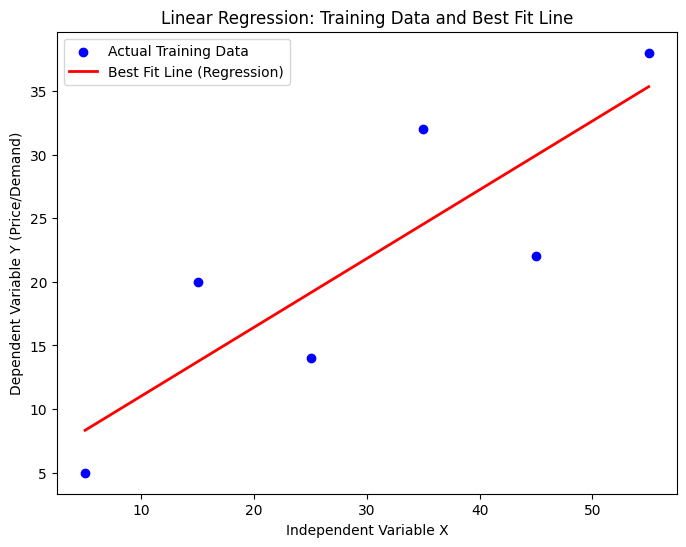

In [24]:
# 1. Regression Model Setup ('Statistical Forecasting - Regression Model')

# Training Data
X_train = np.array([5, 15, 25, 35, 45, 55]).reshape((-1, 1))
y_train = np.array([5, 20, 14, 32, 22, 38]) # Example historical prices/demand

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)

plt.figure(figsize=(8, 6))

plt.scatter(X_train, y_train, color='blue', label='Actual Training Data')

# Plot the best-fit line
plt.plot(X_train, y_pred_train, color='red', linewidth=2, label='Best Fit Line (Regression)')

plt.title('Linear Regression: Training Data and Best Fit Line')
plt.xlabel('Independent Variable X')
plt.ylabel('Dependent Variable Y (Price/Demand)')
plt.legend()

In [7]:
# 2. Price Prediction
# Predict the next 24 hourly prices by using X values from 60 to 290 
# (simulating the next 24 steps).
X_predict = np.arange(60, 60 + 24 * 10, 10).reshape((-1, 1)) # Steps 60, 70, 80, ..., 290
predicted_prices_24h = model.predict(X_predict)

# Ensure no negative prices
predicted_prices_24h[predicted_prices_24h < 0] = 0.01

print("--- Predicted 24-Hour Prices (from Regression Model) ---")
print(np.round(predicted_prices_24h, 2))

--- Predicted 24-Hour Prices (from Regression Model) ---
[ 38.03  43.43  48.83  54.23  59.63  65.03  70.43  75.83  81.23  86.63
  92.03  97.43 102.83 108.23 113.63 119.03 124.43 129.83 135.23 140.63
 146.03 151.43 156.83 162.23]


In [9]:
# 3. BESS Optimization Parameters
capacity = 100 # kWh
initial_charge_level = 50 # kWh
charge_eff = 0.95
discharge_eff = 0.95

In [11]:
# 4. Run Optimization
total_profit, decisions, final_charge, avg_price, charge_levels_over_time = optimize_bess(
    predicted_prices_24h, 
    capacity, 
    initial_charge_level, 
    charge_eff, 
    discharge_eff
)

In [25]:
# 5. Results & Analysis
print("\n--- BESS Optimization Results ---")
print(f"Average Predicted Price: ${avg_price:.2f}")
print(f"Total Arbitrage Profit: ${total_profit:.2f}")

# The cost saved is essentially the total profit from buying low and selling high.
cost_saved = total_profit
profit_percent = (total_profit / (predicted_prices_24h.sum() * 0.1 * capacity)) * 100 if predicted_prices_24h.sum() > 0 else 0 
# Note: Profit % calculation is an illustrative guess based on total possible charge/discharge value.

print(f"Approximate Cost Saved (Profit): ${cost_saved:.2f}")
print(f"Final Charge Level: {final_charge:.2f} kWh")

print("\n--- Hourly Decisions and State of Charge (SoC) ---")
print(f"{'Hour':<5}{'Price':<8}{'Decision':<12}{'SoC (Start)':<12}{'SoC (End)':<10}")
print("-" * 47)
for i in range(24):
    print(f"{i+1:<5}{predicted_prices_24h[i]:<8.2f}{decisions[i]:<12}{charge_levels_over_time[i]:<12.2f}{charge_levels_over_time[i+1]:<10.2f}")

print("\n--- Key Takeaways ---")
print(f"When to Charge: {', '.join([str(i+1) for i, d in enumerate(decisions) if d == 'Charge'])}")
print(f"When to Discharge: {', '.join([str(i+1) for i, d in enumerate(decisions) if d == 'Discharge'])}")
print(f"When to Hold: {', '.join([str(i+1) for i, d in enumerate(decisions) if d == 'Hold'])}")


--- BESS Optimization Results ---
Average Predicted Price: $100.13
Total Arbitrage Profit: $10490.11
Approximate Cost Saved (Profit): $10490.11
Final Charge Level: 0.00 kWh

--- Hourly Decisions and State of Charge (SoC) ---
Hour Price   Decision    SoC (Start) SoC (End) 
-----------------------------------------------
1    38.03   Charge      50.00       59.50     
2    43.43   Charge      59.50       69.00     
3    48.83   Charge      69.00       78.50     
4    54.23   Charge      78.50       88.00     
5    59.63   Charge      88.00       97.50     
6    65.03   Charge      97.50       99.88     
7    70.43   Charge      99.88       99.99     
8    75.83   Charge      99.99       100.00    
9    81.23   Charge      100.00      100.00    
10   86.63   Charge      100.00      100.00    
11   92.03   Hold        100.00      100.00    
12   97.43   Hold        100.00      100.00    
13   102.83  Hold        100.00      100.00    
14   108.23  Hold        100.00      100.00    
15   1

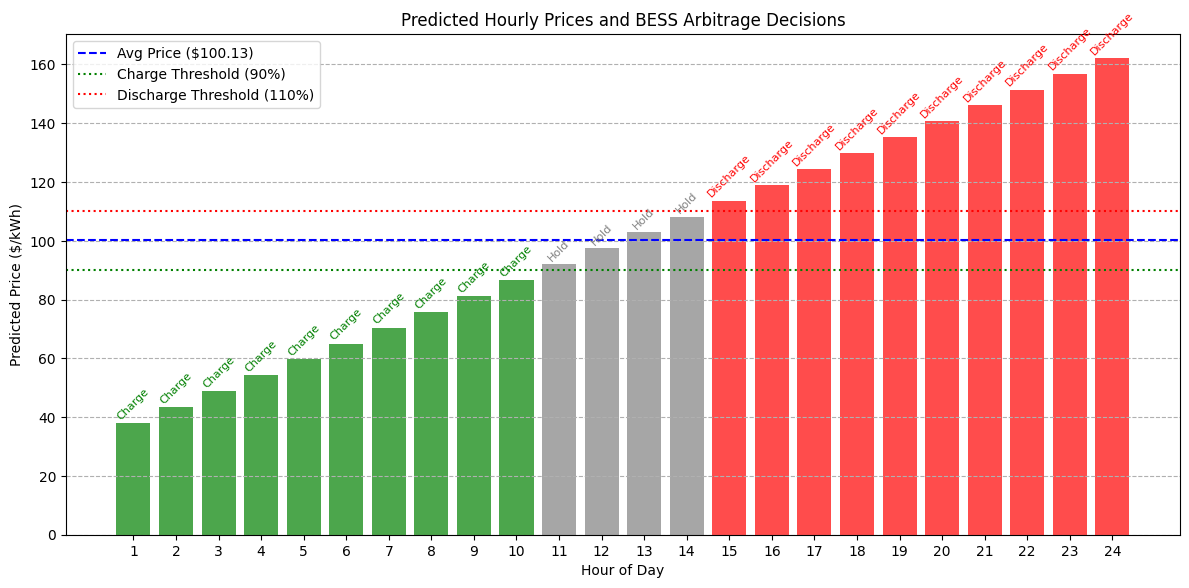

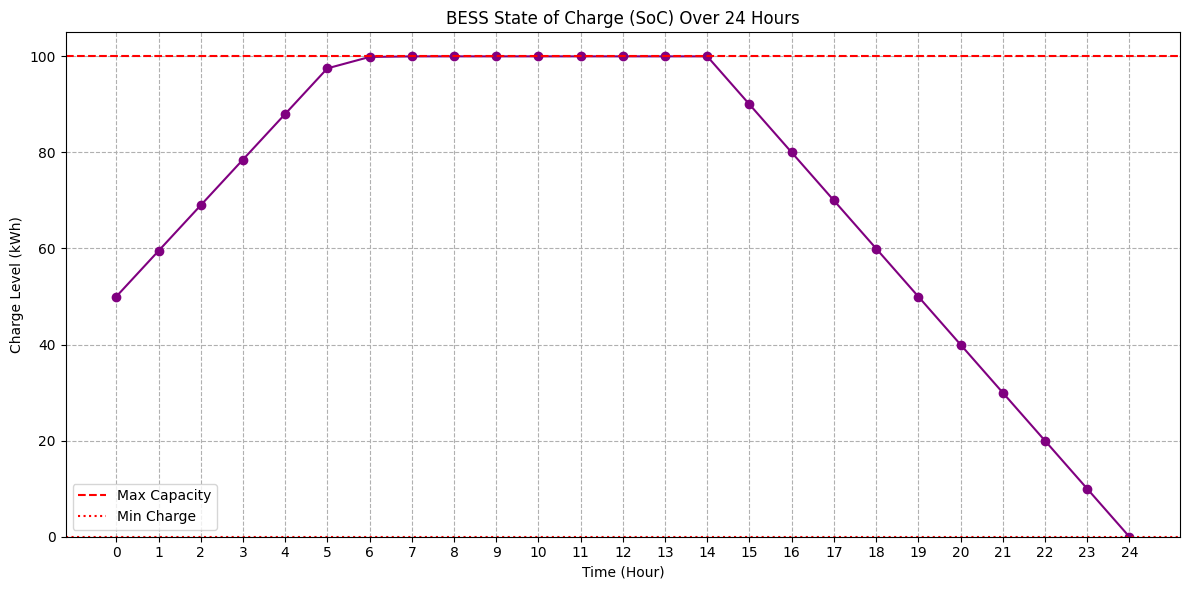

In [17]:
# 6. Plotting Code

hours = np.arange(1, 25)

# --- Plot 1: Predicted Price and Decision ---
decision_colors = {'Charge': 'green', 'Discharge': 'red', 'Hold': 'gray'}
colors = [decision_colors[d] for d in decisions]

plt.figure(figsize=(12, 6))
plt.bar(hours, predicted_prices_24h, color=colors, alpha=0.7)

# Add decision labels above the bars
for i in range(len(hours)):
    plt.text(hours[i], predicted_prices_24h[i] + 0.5, decisions[i], 
             ha='center', va='bottom', fontsize=8, rotation=45, color=colors[i])

plt.axhline(avg_price, color='blue', linestyle='--', label=f'Avg Price (${avg_price:.2f})')
plt.axhline(avg_price * 0.9, color='green', linestyle=':', label='Charge Threshold (90%)')
plt.axhline(avg_price * 1.1, color='red', linestyle=':', label='Discharge Threshold (110%)')

plt.title('Predicted Hourly Prices and BESS Arbitrage Decisions')
plt.xlabel('Hour of Day')
plt.ylabel('Predicted Price ($/kWh)')
plt.xticks(hours)
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.tight_layout()

# --- Plot 2: State of Charge (SoC) Over Time ---
hours_soc = np.arange(0, 25)

plt.figure(figsize=(12, 6))
plt.plot(hours_soc, charge_levels_over_time, marker='o', linestyle='-', color='purple')
plt.axhline(capacity, color='red', linestyle='--', label='Max Capacity')
plt.axhline(0, color='red', linestyle=':', label='Min Charge')

plt.title('BESS State of Charge (SoC) Over 24 Hours')
plt.xlabel('Time (Hour)')
plt.ylabel('Charge Level (kWh)')
plt.xticks(hours_soc, [str(i) for i in hours_soc])
plt.ylim(0, capacity + 5)
plt.legend()
plt.grid(axis='both', linestyle='--')
plt.tight_layout()